# fmdtools Paper Demonstration

This notebook uses a high-level model of a multirotor drone to illustrate the different levels of model fidelity that can be defined and analyzed in fmdtools. The intent of the fmdtools model represenation is to be able to iteratively make a model more detailed to support the design process. Specifically, we'd like to be able to:
- Start with a Network representation of the system to see the network properties of the high-level system structure (Netowrk Model)
- Be able to simulate the system prior to understanding the full system dynamics (Static Propagation Model)
- Be able to add system dynamics (Dynamic Propagation Model)
- Be able to add component architectures as needed (Hierarchical Model)

A version of this notebook was presented in the paper:

[Hulse, D., Walsh, H., Dong, A., Hoyle, C., Tumer, I., Kulkarni, C., & Goebel, K. (2021). fmdtools: A Fault Propagation Toolkit for Resilience Assessment in Early Design. International Journal of Prognostics and Health Management, 12(3)](https://doi.org/10.36001/ijphm.2021.v12i3.2954)

At that time, fmdtools was not developed with inheritence in mind, and thus the iterative update of models meant either over-writing an existing model structure (losing high-level design information) or copy-pasting model definition (duplicating system definition).

Since then, we have been evolving fmdtools classes to be more modular in support inheritance. The following demo was thus adapted with this in mind, to show not only the progression of analysis types, but also to show how more detailed models can inherit from early model structures to maintain a consistent system representation.

## Initial Network Model


In our initial model, all we have is the flows, functions, and connections between them. These are set up in a model class as shown:

In [1]:
from fmdtools.define.architecture.function import FunctionArchitecture
from fmdtools.define.block.function import GenericFxn
class Drone(FunctionArchitecture):
    __slots__=()
    default_sp={}
    def init_architecture(self, **kwargs):
        #add flows to the model
        self.add_flow("force_st")
        self.add_flow("force_lin")
        self.add_flow("ee_1")
        self.add_flow("ee_mot")
        self.add_flow("ee_ctl")
        self.add_flow("ctl")
        self.add_flow("dofs")
        self.add_flow("des_traj")
        # add functions to the model
        self.add_fxn("store_ee", GenericFxn, "ee_1", "force_st")
        self.add_fxn("dist_ee", GenericFxn, "ee_1", "ee_mot", "ee_ctl", "force_st")
        self.add_fxn("affect_dof", GenericFxn, "ee_mot", "ctl", "dofs", "force_lin")
        self.add_fxn("ctl_dof", GenericFxn, "ee_ctl", "des_traj", "ctl", "dofs", "force_st")
        self.add_fxn("plan_path", GenericFxn, "ee_ctl", "des_traj", "force_st", "dofs")
        self.add_fxn("hold_payload", GenericFxn, "dofs", "force_lin", "force_st")
        self.add_fxn("view_env", GenericFxn, "dofs")

mdl = Drone()

## Setting Node Positions

As shown below, it can be difficult to make sense of a model structure using the default graph layout. We might instead want to see something that more closely approximates a flow chart of the system.

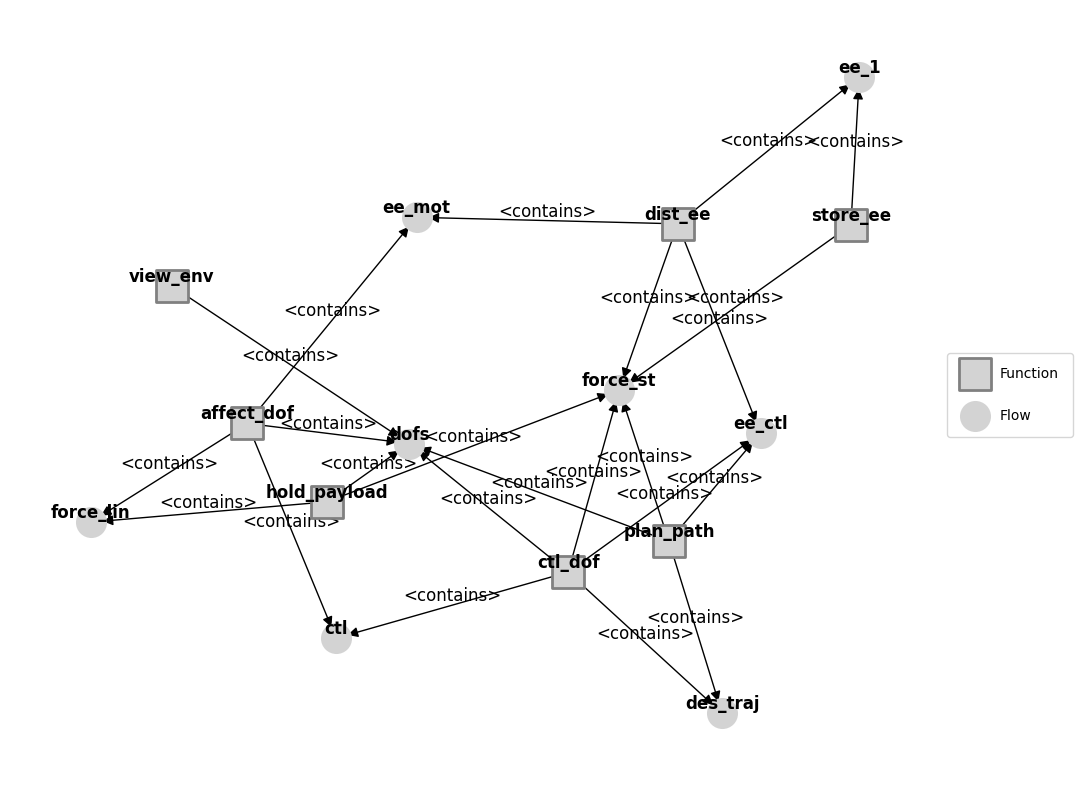

In [2]:
from fmdtools.analyze.graph import FunctionArchitectureGraph, FunctionArchitectureFxnGraph
mdl = Drone()
mg = FunctionArchitectureGraph(mdl)
fig, ax = mg.draw()

To set node positions, we can use ``Graph.move_nodes``, which lets one drag the nodes to their desired locations. Node that while these node positions become attributes of the object (for future display) it is good practice to save node locations when one is done in the script so you don't have to move them every time.

In [3]:
# %matplotlib qt5
# gi = mg.move_nodes()

In [4]:
# %matplotlib inline

In [5]:
mg.pos={'store_ee': [-0.85, -0.63],
        'dist_ee': [-0.79, 0.09],
        'affect_dof': [0.69, 0.34],
        'ctl_dof': [-0.01, 0.45],
        'plan_path': [-0.55, 0.8],
        'hold_payload': [0.22, -0.72],
        'view_env': [0.77, -0.63],
        'force_st': [-0.29, -0.66],
        'force_lin': [0.24, -0.13],
        'ee_1': [-0.82, -0.26],
        'ee_mot': [-0.1, 0.14],
        'ee_ctl': [-0.83, 0.45],
        'ctl': [0.35, 0.61],
        'dofs': [0.72, -0.06],
        'des_traj': [0.09, 0.78]}

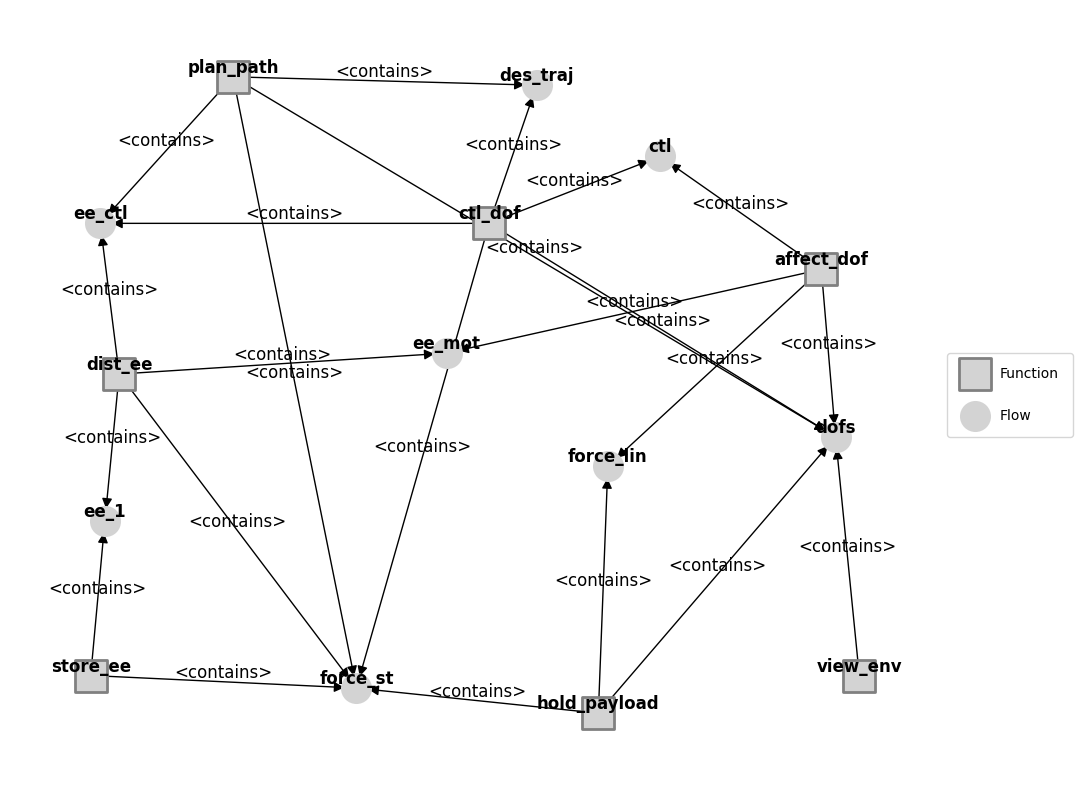

In [6]:
fig, ax = mg.draw()

Note that a variety of views of the model graph can be used for analysis/visualization. Below we use the ModelFxnGraph

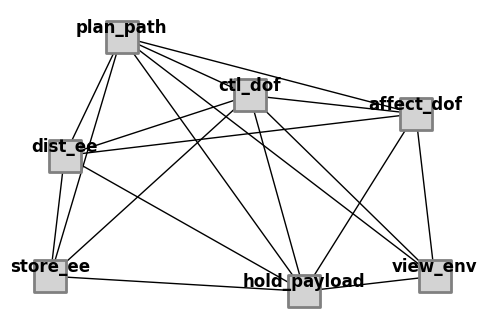

In [7]:
fg = FunctionArchitectureFxnGraph(mdl)

fg.pos={'store_ee': [-0.85, -0.63],
        'dist_ee': [-0.79, 0.09],
        'affect_dof': [0.69, 0.34],
        'ctl_dof': [-0.01, 0.45],
        'plan_path': [-0.55, 0.8],
        'hold_payload': [0.22, -0.72],
        'view_env': [0.77, -0.63]}
fg.set_edge_labels(title='', subtext='')
fig, ax = fg.draw(figsize=(6,4), withlegend=False)

### Network Analysis

A network model can be used to compute network metrics and visualize network vulnerabilities.

We can calculate network metrics using calc_aspl, calc_modularity, and calc_robustness_coefficient in the `networks` module.

In [8]:
aspl = fg.calc_aspl()
q = fg.calc_modularity()
rc = fg.calc_robustness_coefficient()

print("ASPL: %.2f" % round(aspl, 2))
print("Modularity: %.2f" % round(q,2))
print("Robustness Coefficient: %.2f" % round(rc,2))

ASPL: 1.14
Modularity: 0.00
Robustness Coefficient: 99.31


Next, we visualize network vulnerabilities using find_bridging_nodes and find_high_degree_nodes.

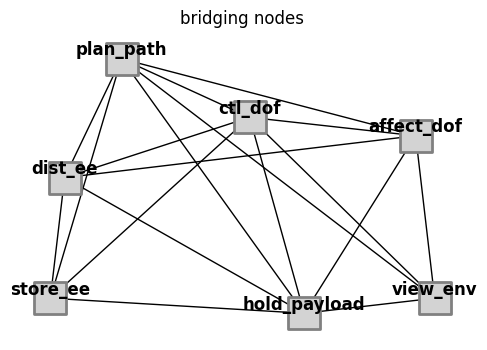

In [9]:
fig_bridging_nodes, ax_bridging_nodes = fg.plot_bridging_nodes(figsize=(6,4), withlegend=False)
fig_bridging_nodes.savefig('bridgingnodes.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, no bridging notes are found. This is somewhat expected, since functiongraph functions are for the most part all connected to the same flows.

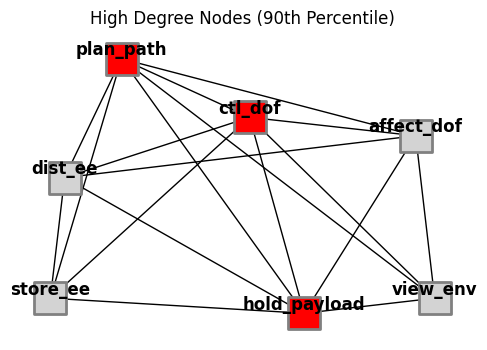

In [10]:
fig_high_degree_nodes, ax_high_degree_nodes = fg.plot_high_degree_nodes(figsize=(6,4), withlegend=False)
fig_bridging_nodes.savefig('highdegreenodes.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0)

However, some functions do have more connected to them than others. In this case-, path planning and control, along with the structure.

High degree nodes (along with their degrees) and bridging nodes are also obtainable as lists.

In [11]:
print('Bridging Nodes:', fg.find_bridging_nodes())
print('High Degree Nodes:',fg.find_high_degree_nodes())

Bridging Nodes: []
High Degree Nodes: [('ctl_dof', 6), ('plan_path', 6), ('hold_payload', 6)]


Finally, we can plot the degree distribution of the network using degree_dist.

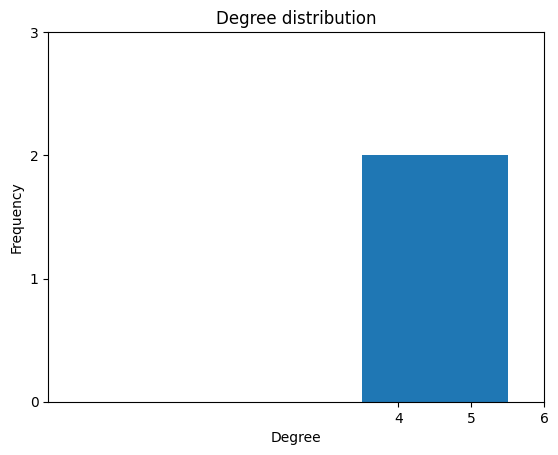

In [12]:
fig = fg.plot_degree_dist()
fig.savefig('degreedist.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

The above analysis includes only function nodes. It is also possible to treat the entire model graph (containing both functions and flows) as a unipartite-like graph and perform similar analysis on both function and flow nodes.

In [13]:
aspl = mg.calc_aspl()
q = mg.calc_modularity()
rc = mg.calc_robustness_coefficient()

print("ASPL, functions and flows: %.2f" % round(aspl, 2))
print("Modularity, functions and flows: %.2f" % round(q,2))
print("Robustness Coefficient, functions and flows: %.2f" % round(rc,2))

ASPL, functions and flows: 2.30
Modularity, functions and flows: 0.32
Robustness Coefficient, functions and flows: 87.28


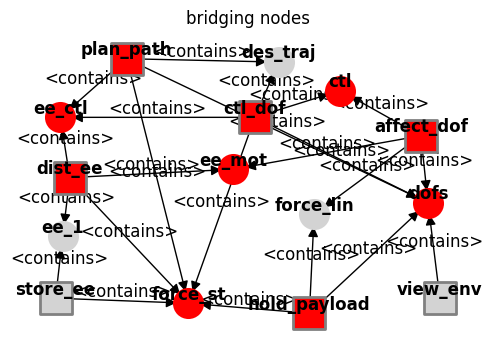

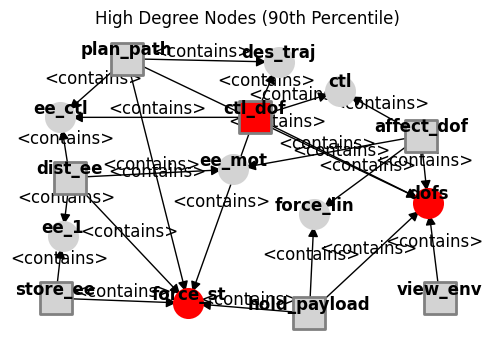

In [14]:
fig_bridging_nodes, ax_bridging_nodes = mg.plot_bridging_nodes(figsize=(6,4), withlegend=False)
fig_high_degree_nodes, ax_high_degree_nodes = mg.plot_high_degree_nodes(figsize=(6,4), withlegend=False)

In [15]:
print('Bridging Nodes:',mg.find_bridging_nodes())
print('High Degree Nodes:',mg.find_high_degree_nodes())

Bridging Nodes: ['affect_dof', 'ctl', 'ctl_dof', 'dist_ee', 'dofs', 'ee_ctl', 'ee_mot', 'force_st', 'hold_payload', 'plan_path']
High Degree Nodes: [('ctl_dof', 5), ('force_st', 5), ('dofs', 5)]


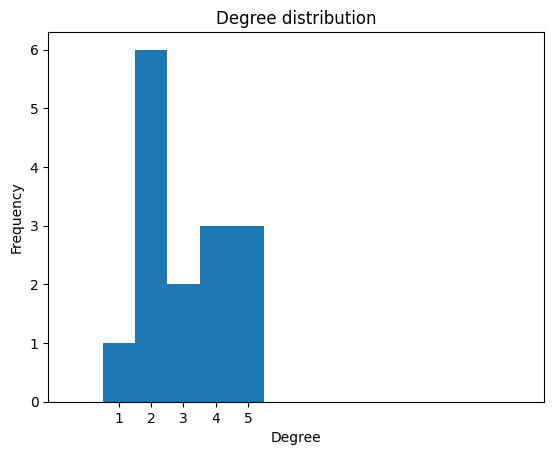

In [16]:
fig = mg.plot_degree_dist()

The SFF model can be simulated with options for simulation time, infection (failure) rate, and recovery (fix) rate. The start node can be selected or chosen randomly. Plotting includes an option for error bars. This models the system's response to a failure using an analogy of an epidemic spreading through a network.

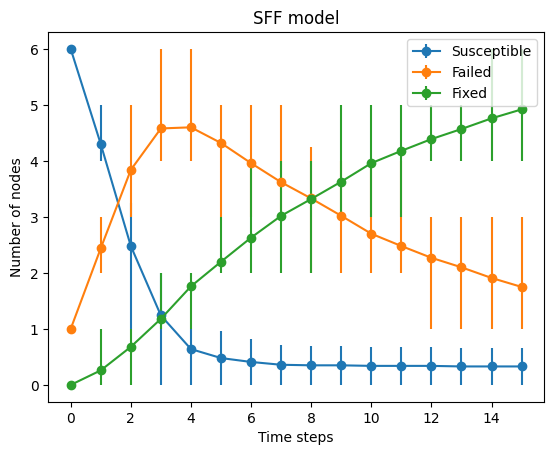

In [17]:
fig = fg.sff_model(endtime=15,pi=.3,pr=.1,start_node='affect_dof',error_bar_option='on')
fig.savefig('sff_model.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0)

## Static Model

In this demonstration, we will use a static representation of the system model to displaygraph views of fault scenarios and produce a static FMEA

The static model is located in `drone_mdl_static.py`.

In [18]:
from drone_mdl_static import Drone as Drone_Static

This model has function definitions for single-timestep behavior. Thus, we can simulate it with methods in `sim.propagate`. In this case, we run all single-fault scenarios.

In [19]:
from fmdtools.sim import propagate
static_mdl = Drone_Static()
endclasses, mdlhists = propagate.single_faults(static_mdl)

SCENARIOS COMPLETE:   0%|          | 0/21 [00:00<?, ?it/s]

SCENARIOS COMPLETE:  62%|██████▏   | 13/21 [00:00<00:00, 125.56it/s]

SCENARIOS COMPLETE: 100%|██████████| 21/21 [00:00<00:00, 126.47it/s]

Here we produce a scenario-based FMEA to show which scenarios are most important in the model:

In [20]:
from fmdtools.analyze import tabulate
static_fmea = tabulate.result_summary_fmea(endclasses, mdlhists, *static_mdl.fxns, *static_mdl.flows)
static_fmea.sort_values('expected_cost', ascending=False)

,degraded,faulty,rate,cost,expected_cost
store_ee_nocharge_t0p0,['view_env'],"['store_ee', 'dist_ee', 'affect_dof', 'ctl_dof...",0.00001,32800.0,32800.0
plan_path_degloc_t0p0,"['store_ee', 'dist_ee', 'affect_dof', 'ctl_dof...",['plan_path'],0.000008,20000.0,16000.0
dist_ee_short_t0p0,"['store_ee', 'view_env', 'ee_1']","['dist_ee', 'affect_dof', 'ctl_dof', 'plan_pat...",0.000003,35500.0,10650.0
ctl_dof_degctl_t0p0,"['store_ee', 'dist_ee', 'affect_dof', 'plan_pa...",['ctl_dof'],0.000008,10000.0,8000.0
affect_dof_ctlbreak_t0p0,"['store_ee', 'view_env']","['dist_ee', 'affect_dof', 'ctl_dof', 'plan_pat...",0.000002,33500.0,6700.0
affect_dof_ctlup_t0p0,"['store_ee', 'view_env']","['dist_ee', 'affect_dof', 'ctl_dof', 'plan_pat...",0.000002,33000.0,6600.0
dist_ee_break_t0p0,"['store_ee', 'view_env']","['dist_ee', 'affect_dof', 'ctl_dof', 'plan_pat...",0.000002,32500.0,6500.0
ctl_dof_noctl_t0p0,"['store_ee', 'view_env']","['dist_ee', 'affect_dof', 'ctl_dof', 'plan_pat...",0.000002,32500.0,6500.0
affect_dof_openc_t0p0,"['store_ee', 'view_env']","['dist_ee', 'affect_dof', 'ctl_dof', 'plan_pat...",0.000001,32700.0,3270.0
affect_dof_short_t0p0,"['store_ee', 'view_env']","['dist_ee', 'affect_dof', 'ctl_dof', 'plan_pat...",0.000001,32700.0,3270.0


In [21]:
print(static_fmea.sort_values('expected_cost', ascending=False).to_latex())

\begin{tabular}{llllll}
\toprule
 & degraded & faulty & rate & cost & expected_cost \\
\midrule
store_ee_nocharge_t0p0 & ['view_env'] & ['store_ee', 'dist_ee', 'affect_dof', 'ctl_dof', 'plan_path', 'hold_payload'] & 0.000010 & 32800.000000 & 32800.000000 \\
plan_path_degloc_t0p0 & ['store_ee', 'dist_ee', 'affect_dof', 'ctl_dof', 'hold_payload', 'view_env', 'force_st', 'force_lin', 'ee_1', 'ee_mot', 'ee_ctl'] & ['plan_path'] & 0.000008 & 20000.000000 & 16000.000000 \\
dist_ee_short_t0p0 & ['store_ee', 'view_env', 'ee_1'] & ['dist_ee', 'affect_dof', 'ctl_dof', 'plan_path', 'hold_payload'] & 0.000003 & 35500.000000 & 10650.000000 \\
ctl_dof_degctl_t0p0 & ['store_ee', 'dist_ee', 'affect_dof', 'plan_path', 'hold_payload', 'view_env', 'force_st', 'force_lin', 'ee_1', 'ee_mot', 'ee_ctl', 'des_traj'] & ['ctl_dof'] & 0.000008 & 10000.000000 & 8000.000000 \\
affect_dof_ctlbreak_t0p0 & ['store_ee', 'view_env'] & ['dist_ee', 'affect_dof', 'ctl_dof', 'plan_path', 'hold_payload'] & 0.000002 & 33500.

We can in turn visualize these faults on the graph representation of the system. Here we will focus on the break of one of the rotors in the AffectDOF function, the effects of which are shown below:

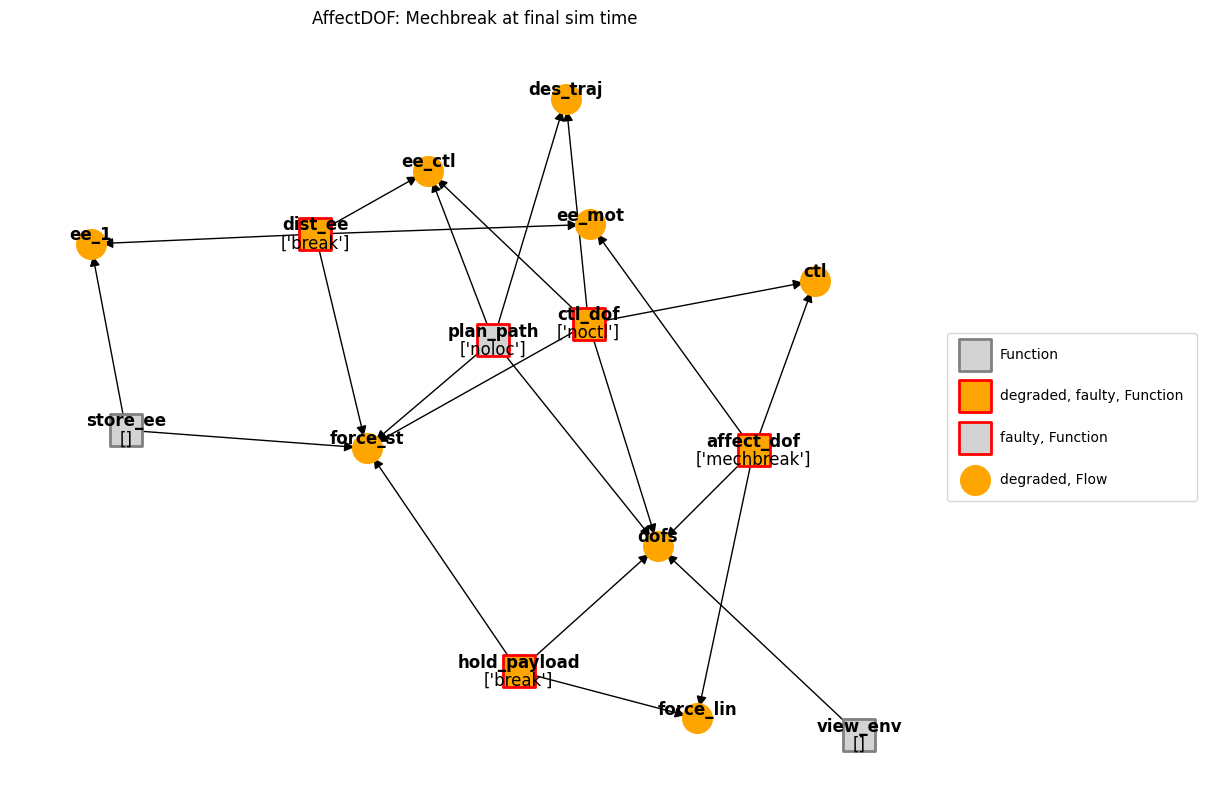

In [22]:
static_mdl = Drone_Static()
result, mdlhist = propagate.one_fault(static_mdl,'affect_dof', 'mechbreak', t=0, desired_result='graph')

result.graph.set_edge_labels(title='')
fig, ax = result.graph.draw(title = 'AffectDOF: Mechbreak at final sim time')
#fig.savefig('static_propagation.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0)

## Dynamic Model

In the dynamic model, we add time ranges and dynamic behaviors to generate behavior-over-time graphs and dynamic/phase-based FMEAs.

This model is located in `drone_mdl_dynamic.py`.

In [23]:
from drone_mdl_dynamic import Drone as Drone_Dynamic

Here we can see how the system operates over time in the nominal case:

In [24]:
# Note: because of the complicated functions, the model must be re-instantiated for each function in order to work in this case

dynamic_mdl = Drone_Dynamic()
endclass, mdlhist = propagate.nominal(dynamic_mdl)

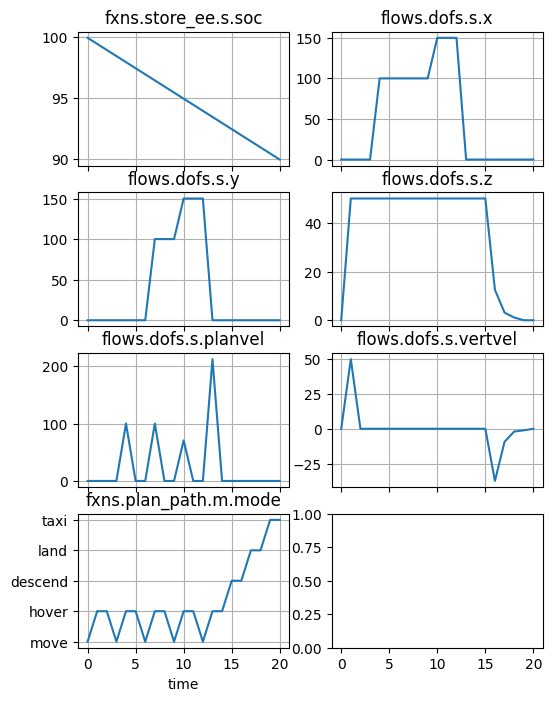

In [25]:
fig, ax = mdlhist.plot_line('fxns.store_ee.s.soc',
                            'flows.dofs.s.x',
                            'flows.dofs.s.y',
                            'flows.dofs.s.z',
                            'flows.dofs.s.planvel',
                            'flows.dofs.s.vertvel',
                            'fxns.plan_path.m.mode')

As shown below, in the case of the break in the AffectDOF function, the system crashes:

In [26]:
dynamic_mdl = Drone_Dynamic()
endclass, mdlhist = propagate.one_fault(dynamic_mdl,'affect_dof', 'mechbreak', time=10)

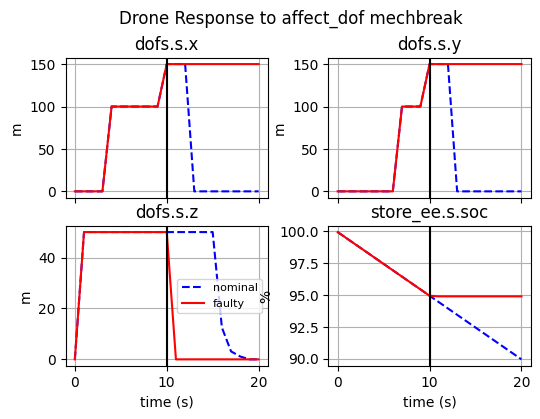

In [27]:
fig, axs = mdlhist.plot_line('dofs.s.x','dofs.s.y','dofs.s.z', 'store_ee.s.soc',
                     title ='Drone Response to affect_dof mechbreak', time_slice=10, 
                     ylabels={'dofs.s.x':'m','dofs.s.y':'m','dofs.s.z':'m','store_ee.s.soc':'%'},\
                     h_padding=0.3, legend_loc=2, xlabel='time (s)')

fig.savefig("fault_behavior.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Finally, we can see how the cost function of this scenario changes over time. As shown, when the fault is injected early, it has a lower cost because it crashes at the landing pad and not in a dangerous area. When it is injected at the end, the cost is minimal because the drone has already landed.

In [28]:
from fmdtools.sim.sample import FaultDomain, FaultSample
from fmdtools.analyze.phases import PhaseMap
mdl_quad_comp = Drone_Dynamic()
fd = FaultDomain(mdl_quad_comp)
fd.add_fault('affect_dof', 'mechbreak')
fs = FaultSample(fd, phasemap = PhaseMap(mdl_quad_comp.sp.phases))
fs.add_fault_phases(args=(5,))

In [29]:
quad_comp_endclasses, quad_comp_mdlhists = propagate.fault_sample(mdl_quad_comp, fs, staged=True)

SCENARIOS COMPLETE:   0%|          | 0/13 [00:00<?, ?it/s]

SCENARIOS COMPLETE:  23%|██▎       | 3/13 [00:00<00:00, 24.46it/s]

SCENARIOS COMPLETE:  54%|█████▍    | 7/13 [00:00<00:00, 29.57it/s]

SCENARIOS COMPLETE: 100%|██████████| 13/13 [00:00<00:00, 40.33it/s]

SCENARIOS COMPLETE: 100%|██████████| 13/13 [00:00<00:00, 36.79it/s]

In [30]:
quad_comp_mdlhists.affect_dof_mechbreak_t17p0.flows.dofs.s.x[-1]

0.0

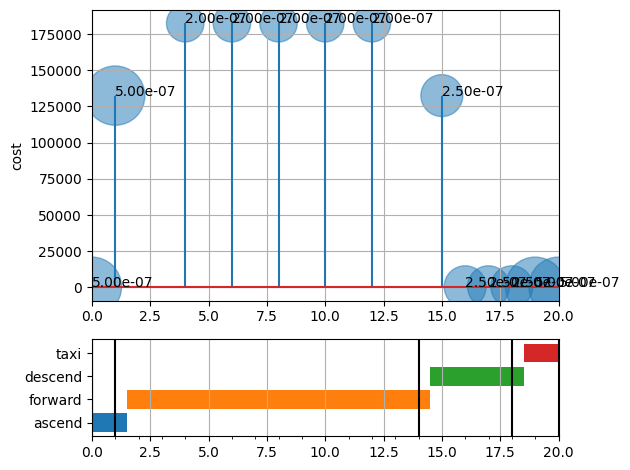

In [31]:
from fmdtools.analyze import phases
fig = phases.samplemetric(fs, quad_comp_endclasses)
fig.savefig("cost_over_time.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [32]:
quad_comp_endclasses

affect_dof_mechbreak5.000000000000001e-07
affect_dof_mechbreak                 500
affect_dof_mechbreak  25.000000000000007
affect_dof_mechbreak5.000000000000001e-07
affect_dof_mechbreak              132500
affect_dof_mechbreak   6625.000000000002
affect_dof_mechbreak2.0000000000000004e-07
affect_dof_mechbreak              182500
affect_dof_mechbreak  3650.0000000000005
affect_dof_mechbreak2.0000000000000004e-07
affect_dof_mechbreak              182500
affect_dof_mechbreak  3650.0000000000005
affect_dof_mechbreak2.0000000000000004e-07
affect_dof_mechbreak              182500
affect_dof_mechbreak  3650.0000000000005
affect_dof_mechbreak2.0000000000000004e-07
affect_dof_mechbreak              182500
affect_dof_mechbreak  3650.0000000000005
affect_dof_mechbreak2.0000000000000004e-07
affect_dof_mechbreak              182500
affect_dof_mechbreak  3650.0000000000005
affect_dof_mechbreak2.5000000000000004e-07
affect_dof_mechbreak              132500
affect_dof_mechbreak   3312.500000000001
af

## Hierarchical Model

In the hierarchical model, we can use the simulation to compare system architectures. First by seeing how faults effect the behaviors in each architechture, then by seing how it affects the overall system resilience. 

This model is located in `drone_mdl_hierarchical.py`.

In [33]:
from drone_mdl_hierarchical import Drone as Drone_Hierarchical

First, we can model how the quadrotor architecture behaves under faults--in this case, identically to the monolythic model:

In [34]:
hierarchical_model = Drone_Hierarchical(p={'arch':'quad'})
endclass, mdlhist = propagate.one_fault(hierarchical_model,'affect_dof', 'rf_mechbreak', time=10)

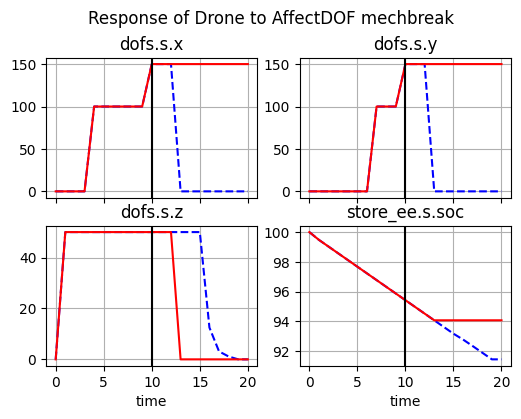

In [35]:
fig, axs = mdlhist.plot_line('dofs.s.x', 'dofs.s.y', 'dofs.s.z', 'store_ee.s.soc',
                        title='Response of Drone to AffectDOF mechbreak', time_slice=10, legend_loc=False)

Then we can see how the octorotor architecture performs in the same case:

In [36]:
hierarchical_model = Drone_Hierarchical(p={'arch':'oct'})
endclass, mdlhist = propagate.one_fault(hierarchical_model,'affect_dof', 'rf_mechbreak', time=10)

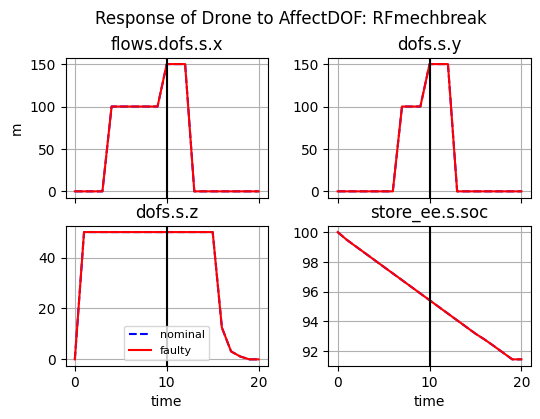

In [37]:
fig, axs = mdlhist.plot_line('flows.dofs.s.x', 'dofs.s.y', 'dofs.s.z', 'store_ee.s.soc',
                     title='Response of Drone to AffectDOF: RFmechbreak', 
                     ylabels={'flows.dofs.s.x':'m','flows.dofs.s.y':'m','flows.dofs.s.z':'m','fxns.store_ee.s.soc':'%'},\
                     time_slice=10, h_padding=0.3, legend_loc=2)

fig.savefig("red_fault_behavior.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, the octorotor architecture enables the quadrotor to recover from the fault and land.

Next, we can compare how each architecture mitigates the set of faults that originiate in each function:
### Quadcopter Resilience

Here we quantify the expected costs of faults originiating in the quadcopter architecture:

In [38]:
mdl_quad = Drone_Hierarchical(p={'arch':'quad'})
mdl_quad.fxns['affect_dof'].m.faultmodes
quad_faults = [('affect_dof', fault) for fault in list(mdl_quad.fxns['affect_dof'].m.faultmodes.keys())]

In [39]:
fd_quad = FaultDomain(mdl_quad)
fd_quad.add_all_fxn_modes("affect_dof")
fd_quad

FaultDomain with faults:
 -('affect_dof', 'short')
 -('affect_dof', 'openc')
 -('affect_dof', 'ctlup')
 -('affect_dof', 'ctldn')
 -('affect_dof', 'ctlbreak')
 -('affect_dof', 'mechbreak')
 -('affect_dof', 'mechfriction')
 -('affect_dof', 'propwarp')
 -('affect_dof', 'propstuck')
 -('affect_dof', 'propbreak')
 -...more

In [40]:
fs_quad = FaultSample(fd_quad, phasemap = PhaseMap(mdl_quad.sp.phases))
fs_quad.add_fault_phases("forward")
fs_quad

FaultSample of scenarios: 
 - affect_dof_short_t8p0
 - affect_dof_openc_t8p0
 - affect_dof_ctlup_t8p0
 - affect_dof_ctldn_t8p0
 - affect_dof_ctlbreak_t8p0
 - affect_dof_mechbreak_t8p0
 - affect_dof_mechfriction_t8p0
 - affect_dof_propwarp_t8p0
 - affect_dof_propstuck_t8p0
 - affect_dof_propbreak_t8p0
 - ... (50 total)

In [41]:
quad_endclasses, quad_mdlhists = propagate.fault_sample(mdl_quad, fs_quad, staged=True)

SCENARIOS COMPLETE:   0%|          | 0/50 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   4%|▍         | 2/50 [00:00<00:02, 18.31it/s]

SCENARIOS COMPLETE:   8%|▊         | 4/50 [00:00<00:02, 18.34it/s]

SCENARIOS COMPLETE:  12%|█▏        | 6/50 [00:00<00:02, 18.35it/s]

SCENARIOS COMPLETE:  16%|█▌        | 8/50 [00:00<00:02, 18.78it/s]

SCENARIOS COMPLETE:  20%|██        | 10/50 [00:00<00:02, 18.04it/s]

SCENARIOS COMPLETE:  26%|██▌       | 13/50 [00:00<00:01, 19.28it/s]

SCENARIOS COMPLETE:  32%|███▏      | 16/50 [00:00<00:01, 20.06it/s]

SCENARIOS COMPLETE:  36%|███▌      | 18/50 [00:00<00:01, 20.03it/s]

SCENARIOS COMPLETE:  42%|████▏     | 21/50 [00:01<00:01, 20.08it/s]

SCENARIOS COMPLETE:  48%|████▊     | 24/50 [00:01<00:01, 20.24it/s]

SCENARIOS COMPLETE:  54%|█████▍    | 27/50 [00:01<00:01, 20.80it/s]

SCENARIOS COMPLETE:  60%|██████    | 30/50 [00:01<00:00, 20.76it/s]

SCENARIOS COMPLETE:  66%|██████▌   | 33/50 [00:01<00:00, 21.26it/s]

SCENARIOS COMPLETE:  72%|███████▏  | 36/50 [00:01<00:00, 21.31it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 39/50 [00:01<00:00, 21.35it/s]

SCENARIOS COMPLETE:  84%|████████▍ | 42/50 [00:02<00:00, 21.83it/s]

SCENARIOS COMPLETE:  90%|█████████ | 45/50 [00:02<00:00, 21.65it/s]

SCENARIOS COMPLETE:  96%|█████████▌| 48/50 [00:02<00:00, 21.70it/s]

SCENARIOS COMPLETE: 100%|██████████| 50/50 [00:02<00:00, 20.65it/s]

In [42]:
quad_tab=quad_endclasses.create_simple_fmea()
quad_tab.sort_values('expected_cost', ascending=False)

,rate,cost,expected_cost
affect_dof_rf_ctlbreak_t8p0,2.000000e-06,185800.0,37160.0
affect_dof_lf_ctlbreak_t8p0,2.000000e-06,185800.0,37160.0
affect_dof_lr_ctlbreak_t8p0,2.000000e-06,185800.0,37160.0
affect_dof_rr_ctlbreak_t8p0,2.000000e-06,185800.0,37160.0
affect_dof_rr_ctlup_t8p0,2.000000e-06,185300.0,37060.0
affect_dof_rr_ctldn_t8p0,2.000000e-06,185300.0,37060.0
affect_dof_rf_ctldn_t8p0,2.000000e-06,185300.0,37060.0
affect_dof_lr_ctlup_t8p0,2.000000e-06,185300.0,37060.0
affect_dof_lr_ctldn_t8p0,2.000000e-06,185300.0,37060.0
affect_dof_rf_ctlup_t8p0,2.000000e-06,185300.0,37060.0


Based on this model, we can calculate some metrics that quantify how resilient the system was to the set of faults, such as the cost of resilience:

In [43]:
quad_res = sum(quad_tab['expected_cost'])
quad_res

749003.0000000001

The overall rate of crashes:

In [44]:
quad_crashes = quad_tab[quad_tab['cost']>100000]
quad_rate = sum(quad_crashes['rate'])
quad_rate

4.040000000000001e-05

The number of crashes:

In [45]:
quad_num_crashes = len(quad_crashes['rate'])
quad_num_crashes

40

The percentage of crashes:

In [46]:
quad_perc_crashes = len(quad_crashes['rate'])/len(quad_tab['rate'])
quad_perc_crashes

0.7843137254901961

### Octocopter Resilience

Here we quantify the expected costs of faults originiating in the octocopter architecture:

In [47]:
mdl_oct = Drone_Hierarchical(p={'arch':'oct'})
mdl_oct.fxns['affect_dof'].m.faultmodes

{'short': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'openc': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'ctlup': Fault(prob=2.0000000000000003e-06, cost=500, phases={}, units='sim'),
 'ctldn': Fault(prob=2.0000000000000003e-06, cost=500, phases={}, units='sim'),
 'ctlbreak': Fault(prob=2.0000000000000003e-06, cost=1000, phases={}, units='sim'),
 'mechbreak': Fault(prob=1.0000000000000002e-06, cost=500, phases={}, units='sim'),
 'mechfriction': Fault(prob=5.000000000000001e-07, cost=500, phases={}, units='sim'),
 'propwarp': Fault(prob=1.0000000000000001e-07, cost=200, phases={}, units='sim'),
 'propstuck': Fault(prob=2.0000000000000002e-07, cost=200, phases={}, units='sim'),
 'propbreak': Fault(prob=3.0000000000000004e-07, cost=200, phases={}, units='sim'),
 'lf_short': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lf_openc': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lf_ctlu

In [48]:
fd_oct = FaultDomain(mdl_oct)
fd_oct.add_all_fxn_modes("affect_dof")
fd_oct

FaultDomain with faults:
 -('affect_dof', 'short')
 -('affect_dof', 'openc')
 -('affect_dof', 'ctlup')
 -('affect_dof', 'ctldn')
 -('affect_dof', 'ctlbreak')
 -('affect_dof', 'mechbreak')
 -('affect_dof', 'mechfriction')
 -('affect_dof', 'propwarp')
 -('affect_dof', 'propstuck')
 -('affect_dof', 'propbreak')
 -...more

In [49]:
fs_oct = FaultSample(fd_oct, phasemap = PhaseMap(mdl_oct.sp.phases))
fs_oct.add_fault_phases("forward")
fs_oct

FaultSample of scenarios: 
 - affect_dof_short_t8p0
 - affect_dof_openc_t8p0
 - affect_dof_ctlup_t8p0
 - affect_dof_ctldn_t8p0
 - affect_dof_ctlbreak_t8p0
 - affect_dof_mechbreak_t8p0
 - affect_dof_mechfriction_t8p0
 - affect_dof_propwarp_t8p0
 - affect_dof_propstuck_t8p0
 - affect_dof_propbreak_t8p0
 - ... (90 total)

In [50]:
oct_endclasses, oct_mdlhists = propagate.fault_sample(mdl_oct, fs_oct, staged=True)

SCENARIOS COMPLETE:   0%|          | 0/90 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   2%|▏         | 2/90 [00:00<00:06, 14.20it/s]

SCENARIOS COMPLETE:   4%|▍         | 4/90 [00:00<00:06, 13.77it/s]

SCENARIOS COMPLETE:   7%|▋         | 6/90 [00:00<00:06, 13.93it/s]

SCENARIOS COMPLETE:   9%|▉         | 8/90 [00:00<00:05, 14.08it/s]

SCENARIOS COMPLETE:  11%|█         | 10/90 [00:00<00:05, 14.20it/s]

SCENARIOS COMPLETE:  13%|█▎        | 12/90 [00:00<00:05, 14.17it/s]

SCENARIOS COMPLETE:  16%|█▌        | 14/90 [00:00<00:05, 14.22it/s]

SCENARIOS COMPLETE:  18%|█▊        | 16/90 [00:01<00:05, 14.26it/s]

SCENARIOS COMPLETE:  20%|██        | 18/90 [00:01<00:05, 14.24it/s]

SCENARIOS COMPLETE:  22%|██▏       | 20/90 [00:01<00:04, 14.24it/s]

SCENARIOS COMPLETE:  24%|██▍       | 22/90 [00:01<00:04, 14.30it/s]

SCENARIOS COMPLETE:  27%|██▋       | 24/90 [00:01<00:04, 14.26it/s]

SCENARIOS COMPLETE:  29%|██▉       | 26/90 [00:01<00:04, 14.28it/s]

SCENARIOS COMPLETE:  31%|███       | 28/90 [00:01<00:04, 13.97it/s]

SCENARIOS COMPLETE:  33%|███▎      | 30/90 [00:02<00:04, 13.77it/s]

SCENARIOS COMPLETE:  36%|███▌      | 32/90 [00:02<00:04, 13.64it/s]

SCENARIOS COMPLETE:  38%|███▊      | 34/90 [00:02<00:04, 13.59it/s]

SCENARIOS COMPLETE:  40%|████      | 36/90 [00:02<00:03, 13.78it/s]

SCENARIOS COMPLETE:  42%|████▏     | 38/90 [00:02<00:03, 13.89it/s]

SCENARIOS COMPLETE:  44%|████▍     | 40/90 [00:02<00:03, 14.01it/s]

SCENARIOS COMPLETE:  47%|████▋     | 42/90 [00:03<00:03, 13.80it/s]

SCENARIOS COMPLETE:  49%|████▉     | 44/90 [00:03<00:03, 13.68it/s]

SCENARIOS COMPLETE:  51%|█████     | 46/90 [00:03<00:03, 13.83it/s]

SCENARIOS COMPLETE:  53%|█████▎    | 48/90 [00:03<00:03, 13.74it/s]

SCENARIOS COMPLETE:  56%|█████▌    | 50/90 [00:03<00:02, 13.83it/s]

SCENARIOS COMPLETE:  58%|█████▊    | 52/90 [00:03<00:02, 13.97it/s]

SCENARIOS COMPLETE:  60%|██████    | 54/90 [00:03<00:02, 13.77it/s]

SCENARIOS COMPLETE:  62%|██████▏   | 56/90 [00:04<00:02, 13.93it/s]

SCENARIOS COMPLETE:  64%|██████▍   | 58/90 [00:04<00:02, 14.01it/s]

SCENARIOS COMPLETE:  67%|██████▋   | 60/90 [00:04<00:02, 14.12it/s]

SCENARIOS COMPLETE:  69%|██████▉   | 62/90 [00:04<00:02, 13.97it/s]

SCENARIOS COMPLETE:  71%|███████   | 64/90 [00:04<00:01, 14.16it/s]

SCENARIOS COMPLETE:  73%|███████▎  | 66/90 [00:04<00:01, 14.03it/s]

SCENARIOS COMPLETE:  76%|███████▌  | 68/90 [00:04<00:01, 13.81it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 70/90 [00:05<00:01, 13.92it/s]

SCENARIOS COMPLETE:  80%|████████  | 72/90 [00:05<00:01, 13.96it/s]

SCENARIOS COMPLETE:  82%|████████▏ | 74/90 [00:05<00:01, 14.12it/s]

SCENARIOS COMPLETE:  84%|████████▍ | 76/90 [00:05<00:01, 13.99it/s]

SCENARIOS COMPLETE:  87%|████████▋ | 78/90 [00:05<00:00, 14.29it/s]

SCENARIOS COMPLETE:  89%|████████▉ | 80/90 [00:05<00:00, 13.97it/s]

SCENARIOS COMPLETE:  91%|█████████ | 82/90 [00:05<00:00, 14.09it/s]

SCENARIOS COMPLETE:  93%|█████████▎| 84/90 [00:06<00:00, 14.10it/s]

SCENARIOS COMPLETE:  96%|█████████▌| 86/90 [00:06<00:00, 14.20it/s]

SCENARIOS COMPLETE:  98%|█████████▊| 88/90 [00:06<00:00, 14.19it/s]

SCENARIOS COMPLETE: 100%|██████████| 90/90 [00:06<00:00, 13.93it/s]

SCENARIOS COMPLETE: 100%|██████████| 90/90 [00:06<00:00, 13.99it/s]

In [51]:
oct_tab = oct_endclasses.create_simple_fmea()
oct_tab.sort_values('expected_cost', ascending=False)

,rate,cost,expected_cost
affect_dof_lr2_ctlbreak_t8p0,2.000000e-06,1000.0,200.0
affect_dof_ctlbreak_t8p0,2.000000e-06,1000.0,200.0
affect_dof_rf2_ctlbreak_t8p0,2.000000e-06,1000.0,200.0
affect_dof_lf2_ctlbreak_t8p0,2.000000e-06,1000.0,200.0
affect_dof_rr2_ctlbreak_t8p0,2.000000e-06,1000.0,200.0
...,...,...,...
affect_dof_lf2_propwarp_t8p0,1.000000e-07,200.0,2.0
affect_dof_lr2_propwarp_t8p0,1.000000e-07,200.0,2.0
affect_dof_rr_propwarp_t8p0,1.000000e-07,200.0,2.0
affect_dof_rr2_propwarp_t8p0,1.000000e-07,200.0,2.0


Based on this model, we can calculate some metrics that quantify how resilient the system was to the set of faults, such as the cost of resilience:

In [52]:
oct_res = sum(oct_tab['expected_cost'])
oct_res

4743.000000000001

The overall rate of crashes:

In [53]:
oct_crashes = oct_tab[oct_tab['cost']>100000]
oct_rate = sum(oct_crashes['rate'])
oct_rate

0

Number of crashes:

In [54]:
oct_num_crashes = len(oct_crashes['rate'])
oct_num_crashes

0

Percent of crashes:

In [55]:
oct_perc_crashes = len(oct_crashes['rate'])/len(oct_tab['rate'])
oct_perc_crashes

0.0